In [1]:
"""
Land cover assessments for MODIS and VIIRS AFDs for the Southern Rockies

Data sources:
    - United States Forest Service (USFS) TreeMap c.a. 2016
    - Sentinel-based aspen cover (Cook et al.)
    - LANDFIRE Existing Vegetation Type (EVT) proportional cover
    - LANDFIRE Canopy Bulk Density (CBD) mean
    - LANDIFRE Canopy Base Height (CBH) mean
    - LANDFIRE Canopy Cover (CC) percentage
    
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [ ]:
# Load the VIIRS active fire detections (AFD)
# These are "pixel area" data for fires with > 10 observations in the Southern Rockies

In [2]:
fp = os.path.join(projdir,f'data/spatial/mod/VIIRS/vnp14img_geo_srm_pix_area_aspenfires_nodup.gpkg')
afds = gpd.read_file(fp)
afds.columns

Index(['longitude', 'latitude', 'fire_mask', 'confidence', 'daynight',
       'acq_date', 'acq_time', 'granule_id', 'geo_id', 'frp', 'iot4', 'iot5',
       'sample', 'along_scan', 'along_track', 'scan_angle', 'pix_area',
       'afdID', 'Fire_ID', 'Fire_Name', 'START_YEAR', 'DISCOVERY_DATE',
       'WF_CESSATION_DATE', 'acq_month', 'acq_year', 'obs_count', 'obs_id',
       'acq_datetime', 'geometry'],
      dtype='object')

In [3]:
print(f"There are [{len(afds['Fire_ID'].unique())}] fire events in the Southern Rockies (2018-2023)")

There are [50] fire events in the Southern Rockies (2018-2023)


In [104]:
# tidy columns for simplicity.
afds_ = afds[['afdID','acq_date','acq_year','daynight','frp','geometry']]
afds_.head()

,afdID,acq_date,acq_year,daynight,frp,geometry
0,468,2018-06-01,2018,Day,7.603679,"POLYGON ((-1031854.255 1666193.625, -1031854.2..."
1,469,2018-06-01,2018,Day,48.685238,"POLYGON ((-1031892.316 1666624.052, -1031892.3..."
2,470,2018-06-01,2018,Day,48.685238,"POLYGON ((-1032327.721 1666569.543, -1032327.7..."
3,471,2018-06-01,2018,Day,25.084015,"POLYGON ((-1032764.880 1666513.807, -1032764.8..."
4,472,2018-06-01,2018,Day,48.685238,"POLYGON ((-1032366.169 1666999.460, -1032366.1..."


In [114]:
bounds = afds_.total_bounds # for cropping

## USFS TreeMap c.a. 2016

We obtained TreeMap summaries from Google Earth Engine (GEE) representing the species histogram, mean live basal area (BALIVE), and mean canopy percent (CANOPYPCT). 

In [73]:
# Load the summary table (from GEE reductions)
fp = os.path.join(projdir,'data/earth-engine/exports/treemap/vnp14img_treemap-fortypcd.csv')
fortypcd = pd.read_csv(fp)
fortypcd.drop(columns=['system:index','.geo'], inplace=True) # drop the GEE id and .geo columns
fortypcd.head()

,182,185,201,221,261,267,281,369,371,901,971,afdID
0,37.525490,29.494118,23.129412,154.333333,13.666667,0.023529,1.690196,9.082353,1.000000,1.125490,31.352941,23291
1,25.227451,11.874510,105.866667,52.172549,35.941176,20.886275,2.498039,8.666667,1.458824,11.431373,16.333333,23298
2,NaN,0.274510,7.129412,72.964706,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,23299
3,1.498039,1.498039,50.184314,226.356863,8.247059,NaN,NaN,NaN,1.000000,NaN,14.184314,23300
4,NaN,NaN,11.760784,264.745098,7.800000,NaN,NaN,NaN,3.250980,NaN,NaN,23307


In [ ]:
# Pivot the tree species table and tidy

In [74]:
# Pivot longer and join to get species name
fortypcd_l = fortypcd.melt(id_vars=['afdID'], var_name='FORTYPCD', value_name='count')
fortypcd_l['FORTYPCD'] = fortypcd_l['FORTYPCD'].astype(int)
# Check on the results
fortypcd_l = fortypcd_l.sort_values(by=['afdID'])
fortypcd_l.head(10)

,afdID,FORTYPCD,count
532631,468,971,1.376471
117807,468,201,0.007843
428925,468,371,16.749020
325219,468,281,1.000000
221513,468,261,NaN
14101,468,182,14.000000
480778,468,901,0.003922
273366,468,267,NaN
169660,468,221,40.258824
377072,468,369,42.533333


In [75]:
# Drop 'NaN' counts (species not present in the AFD)
fortypcd_l.dropna(subset=['count'], inplace=True)
print("Dropped NA values.")

Dropped NA values.


In [77]:
# merge with AFD summary to get forest species name
fortypcd_l = fortypcd_l.merge(species_df, on='FORTYPCD', how='left')
fortypcd_l = fortypcd_l[['afdID','FORTYPCD','SpeciesName','count']]
# remove 0s (this is a function of how GEE does reductions on the edge of polygons)
fortypcd_l['count'] = fortypcd_l['count'].round().astype(int) # set as integer type
fortypcd_l = fortypcd_l[fortypcd_l['count'] > 0]

fortypcd_l.head()

,afdID,FORTYPCD,SpeciesName,count
0,468,971,Deciduous oak woodland,1
2,468,371,California mixed conifer,17
3,468,281,Lodgepole pine,1
4,468,182,Rocky Mountain juniper,14
6,468,221,Ponderosa pine,40


In [78]:
# load the lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.head()

,FORTYPCD,SpeciesName
0,101,Jack pine
1,102,Red pine
2,103,Eastern white pine
3,104,Eastern white pine / eastern hemlock
4,105,Eastern hemlock


In [79]:
# Calculate the total forest count and percent cover for each species
total_counts = fortypcd_l.groupby('afdID')['count'].sum().reset_index()
total_counts = total_counts.rename(columns={'count': 'total_count'})

# Join back to the data frame
fortypcd_l_pct = fortypcd_l.merge(total_counts, on='afdID', how='left')
fortypcd_l_pct['PCT_COVER'] = (fortypcd_l_pct['count'] / fortypcd_l_pct['total_count']) * 100
fortypcd_l_pct.head(12)

,afdID,FORTYPCD,SpeciesName,count,total_count,PCT_COVER
0,468,971,Deciduous oak woodland,1,129,0.775194
1,468,371,California mixed conifer,17,129,13.178295
2,468,281,Lodgepole pine,1,129,0.775194
3,468,182,Rocky Mountain juniper,14,129,10.852713
4,468,221,Ponderosa pine,40,129,31.007752
5,468,369,Western juniper,43,129,33.333333
6,468,185,Pinyon / juniper woodland,13,129,10.077519
7,469,369,Western juniper,36,191,18.848168
8,469,901,Aspen,1,191,0.523560
9,469,182,Rocky Mountain juniper,11,191,5.759162


In [ ]:
# combine with BALIVE and CANOPYPCT

In [85]:
fp = os.path.join(projdir,'data/earth-engine/exports/treemap/vnp14img_treemap-balive_canopypct.csv')
tm_stats = pd.read_csv(fp)
tm_stats.drop(columns=['system:index','.geo'], inplace=True)
tm_stats.columns

Index(['182_BALIVE_mean', '182_CANOPYPCT_mean', '185_BALIVE_mean',
       '185_CANOPYPCT_mean', '201_BALIVE_mean', '201_CANOPYPCT_mean',
       '221_BALIVE_mean', '221_CANOPYPCT_mean', '261_BALIVE_mean',
       '261_CANOPYPCT_mean', '281_BALIVE_mean', '281_CANOPYPCT_mean',
       '369_BALIVE_mean', '369_CANOPYPCT_mean', '371_BALIVE_mean',
       '371_CANOPYPCT_mean', '901_BALIVE_mean', '901_CANOPYPCT_mean',
       '971_BALIVE_mean', '971_CANOPYPCT_mean', 'afdID'],
      dtype='object')

In [86]:
metrics_cols = [col for col in tm_stats.columns if '_BALIVE_mean' in col or '_CANOPYPCT_mean' in col]
print("Metrics columns selected for melting:\n", metrics_cols)
tm_stats_l = tm_stats.melt(id_vars=['afdID'], value_vars=metrics_cols, var_name='metric', value_name='value')
tm_stats_l.head()

Metrics columns selected for melting:
 ['182_BALIVE_mean', '182_CANOPYPCT_mean', '185_BALIVE_mean', '185_CANOPYPCT_mean', '201_BALIVE_mean', '201_CANOPYPCT_mean', '221_BALIVE_mean', '221_CANOPYPCT_mean', '261_BALIVE_mean', '261_CANOPYPCT_mean', '281_BALIVE_mean', '281_CANOPYPCT_mean', '369_BALIVE_mean', '369_CANOPYPCT_mean', '371_BALIVE_mean', '371_CANOPYPCT_mean', '901_BALIVE_mean', '901_CANOPYPCT_mean', '971_BALIVE_mean', '971_CANOPYPCT_mean']


,afdID,metric,value
0,23291,182_BALIVE_mean,64.481813
1,23298,182_BALIVE_mean,87.694757
2,23299,182_BALIVE_mean,NaN
3,23300,182_BALIVE_mean,112.031367
4,23307,182_BALIVE_mean,NaN


In [87]:
tm_stats_l['FORTYPCD'] = tm_stats_l['metric'].str.extract(r'(\d+)_')[0].astype(int)
tm_stats_l['metric'] = tm_stats_l['metric'].str.extract(r'_(BALIVE|CANOPYPCT)_mean')[0]
tm_stats_l = tm_stats_l[['afdID','FORTYPCD','metric','value']]
tm_stats_l.dropna(subset=['value'], inplace=True) # drop NaNs
tm_stats_l.head()

,afdID,FORTYPCD,metric,value
0,23291,182,BALIVE,64.481813
1,23298,182,BALIVE,87.694757
3,23300,182,BALIVE,112.031367
5,23310,182,BALIVE,90.715007
6,23314,182,BALIVE,99.186648


In [88]:
tm_stats_lp = tm_stats_l.pivot_table(index=['afdID','FORTYPCD'], columns='metric', values='value')
tm_stats_lp = tm_stats_lp.reset_index() # collapse the index
tm_stats_lp = tm_stats_lp[['afdID','FORTYPCD','BALIVE','CANOPYPCT']]
tm_stats_lp.head()

metric,afdID,FORTYPCD,BALIVE,CANOPYPCT
0,468,182,102.457756,39.896668
1,468,185,56.448120,22.152524
2,468,201,142.369293,64.000000
3,468,221,91.492105,37.454079
4,468,281,16.149900,16.000000


In [89]:
# Join to the FORTYPCD dataframe by afdID and FORTYPCD
treemap = fortypcd_l_pct.merge(tm_stats_lp, on=['afdID','FORTYPCD'], how='left')
treemap = treemap[['afdID','FORTYPCD','SpeciesName','PCT_COVER','BALIVE','CANOPYPCT']]
treemap.head()

,afdID,FORTYPCD,SpeciesName,PCT_COVER,BALIVE,CANOPYPCT
0,468,971,Deciduous oak woodland,0.775194,63.048130,26.408488
1,468,371,California mixed conifer,13.178295,158.677329,56.130167
2,468,281,Lodgepole pine,0.775194,16.149900,16.000000
3,468,182,Rocky Mountain juniper,10.852713,102.457756,39.896668
4,468,221,Ponderosa pine,31.007752,91.492105,37.454079


In [ ]:
# plot distributions of forest species

In [ ]:
# Identify forested plot and the dominant forest type

In [92]:
dtree = treemap.loc[treemap.groupby('afdID')['PCT_COVER'].idxmax()]
dtree.head()

,afdID,FORTYPCD,SpeciesName,PCT_COVER,BALIVE,CANOPYPCT
5,468,369,Western juniper,33.333333,45.489965,26.773939
12,469,221,Ponderosa pine,49.214660,100.477142,39.136735
25,471,221,Ponderosa pine,35.849057,109.681674,45.638633
34,472,221,Ponderosa pine,35.593220,97.096002,42.235074
40,473,221,Ponderosa pine,30.909091,105.838119,43.370741


In [108]:
# Join in FRP
afd_dtree = afds_.merge(dtree, on='afdID', how='left')
print(afd_dtree.columns)
afd_dtree.head()

Index(['afdID', 'acq_date', 'acq_year', 'daynight', 'frp', 'geometry',
       'FORTYPCD', 'SpeciesName', 'PCT_COVER', 'BALIVE', 'CANOPYPCT'],
      dtype='object')


,afdID,acq_date,acq_year,daynight,frp,geometry,FORTYPCD,SpeciesName,PCT_COVER,BALIVE,CANOPYPCT
0,468,2018-06-01,2018,Day,7.603679,"POLYGON ((-1031854.255 1666193.625, -1031854.2...",369.0,Western juniper,33.333333,45.489965,26.773939
1,469,2018-06-01,2018,Day,48.685238,"POLYGON ((-1031892.316 1666624.052, -1031892.3...",221.0,Ponderosa pine,49.214660,100.477142,39.136735
2,470,2018-06-01,2018,Day,48.685238,"POLYGON ((-1032327.721 1666569.543, -1032327.7...",NaN,NaN,NaN,NaN,NaN
3,471,2018-06-01,2018,Day,25.084015,"POLYGON ((-1032764.880 1666513.807, -1032764.8...",221.0,Ponderosa pine,35.849057,109.681674,45.638633
4,472,2018-06-01,2018,Day,48.685238,"POLYGON ((-1032366.169 1666999.460, -1032366.1...",221.0,Ponderosa pine,35.593220,97.096002,42.235074


In [109]:
# tidy the columns and drop NA (no forest types)
afd_dtree = afd_dtree[[
    'afdID', 'acq_date', 'acq_year', 'daynight', 'frp', 
    'FORTYPCD', 'SpeciesName', 'PCT_COVER', 'BALIVE', 'CANOPYPCT', 'geometry']]
afd_dtree = afd_dtree.dropna(subset=['PCT_COVER'])
afd_dtree['FORTYPCD'] = afd_dtree['FORTYPCD'].astype(int)
afd_dtree.head()

,afdID,acq_date,acq_year,daynight,frp,FORTYPCD,SpeciesName,PCT_COVER,BALIVE,CANOPYPCT,geometry
0,468,2018-06-01,2018,Day,7.603679,369,Western juniper,33.333333,45.489965,26.773939,"POLYGON ((-1031854.255 1666193.625, -1031854.2..."
1,469,2018-06-01,2018,Day,48.685238,221,Ponderosa pine,49.214660,100.477142,39.136735,"POLYGON ((-1031892.316 1666624.052, -1031892.3..."
3,471,2018-06-01,2018,Day,25.084015,221,Ponderosa pine,35.849057,109.681674,45.638633,"POLYGON ((-1032764.880 1666513.807, -1032764.8..."
4,472,2018-06-01,2018,Day,48.685238,221,Ponderosa pine,35.593220,97.096002,42.235074,"POLYGON ((-1032366.169 1666999.460, -1032366.1..."
5,473,2018-06-01,2018,Day,25.084015,221,Ponderosa pine,30.909091,105.838119,43.370741,"POLYGON ((-1032806.771 1666944.272, -1032806.7..."


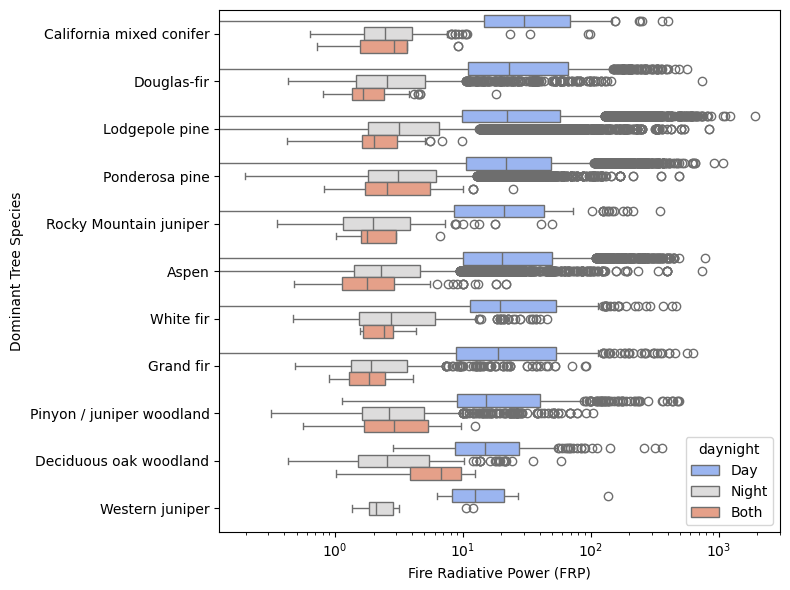

In [110]:
# Plot FRP by EVT group name

# Find the median and sort the evt classes
day = afd_dtree[afd_dtree['daynight'] == 'Day']
med = day.groupby('SpeciesName')['frp'].median().sort_values(ascending=False)
sorted = med.index.tolist()
del day

plt.figure(figsize=(8, 6)) 

sns.boxplot(
    data=afd_dtree, x='frp', y='SpeciesName', hue='daynight', order=sorted, palette='coolwarm', dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Tree Species')

plt.tight_layout()
plt.show()

In [111]:
# save out the summarized TreeMap data.
out_fp = os.path.join(projdir,'data/tabular/mod/vnp14img_geo_srm_treemap-summary.csv')
treemap.to_csv(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/vnp14img_geo_srm_treemap-summary.csv


## LANDFIRE Existing Vegetation Type (EVT) c.a. 2016

In [112]:
fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = evt_da.shape, evt_da.spatial_ref.GeoTransform, evt_da.rio.crs, evt_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt_da[0].dtype}")
gc.collect()

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


3356

In [115]:
evt_da_crop = evt_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del evt_da
gc.collect()

31376

In [116]:
t0 = time.time()

# Get the proportional landcover
afds_evt = compute_band_stats(
    geoms=afds_, 
    image_da=evt_da_crop, 
    id_col='afdID'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 0.60 minutes.

~~~~~~~~~~



In [117]:
afds_evt.head()

,afdID,evt,count,total_pixels,pct_cover
0,468,7011,3.0,285.0,1.052632
1,468,7016,6.0,285.0,2.105263
2,468,7051,20.0,285.0,7.017544
3,468,7052,3.0,285.0,1.052632
4,468,7054,164.0,285.0,57.543860


In [118]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [119]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS','EVT_SBCLS']]
afds_evt_ = afds_evt.merge(lookup, left_on='evt', right_on='VALUE', how='left')
afds_evt_.drop('VALUE', axis=1, inplace=True)
afds_evt_.head()

,afdID,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS,EVT_SBCLS
0,468,7011,3.0,285.0,1.052632,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,Deciduous open tree canopy
1,468,7016,6.0,285.0,2.105263,Colorado Plateau Pinyon-Juniper Woodland,Conifer,Pinyon-Juniper Woodland,Open tree canopy,Evergreen open tree canopy
2,468,7051,20.0,285.0,7.017544,Southern Rocky Mountain Dry-Mesic Montane Mixe...,Conifer,Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...,Closed tree canopy,Evergreen closed tree canopy
3,468,7052,3.0,285.0,1.052632,Southern Rocky Mountain Mesic Montane Mixed Co...,Conifer,Douglas-fir-Grand Fir-White Fir Forest and Woo...,Closed tree canopy,Evergreen closed tree canopy
4,468,7054,164.0,285.0,57.543860,Southern Rocky Mountain Ponderosa Pine Woodland,Conifer,"Ponderosa Pine Forest, Woodland and Savanna",Open tree canopy,Evergreen open tree canopy


In [ ]:
evt_counts = afds_evt_.groupby(['evt','EVT_GP_N']).size().reset_index(name='counts')
evt_counts.sort_values('counts', ascending=False, inplace=True)
evt_counts.head(10)

In [ ]:
# Export a table of the EVT values found in AFD observations
lookup_ = lookup[lookup['VALUE'].isin(afds_evt['evt'].unique())]
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_evt_codes-SRM.csv')
lookup_.to_csv(out_fp)
print(f"Saved to: {out_fp}")

In [ ]:
# Identify the dominant EVT class for each observation
dominant_evt = afds_evt_.loc[afds_evt.groupby('afdID')['pct_cover'].idxmax()]
dominant_evt.head()

In [ ]:
evt_counts['EVT_GP_N'].unique()

In [ ]:
'Aspen Forest, Woodland, and Parkland',
'Douglas-fir-Ponderosa Pine-Lodgepole Pine Forest and Woodland',
'Spruce-Fir Forest and Woodland',
'Ponderosa Pine Forest, Woodland and Savanna',
'Big Sagebrush Shrubland and Steppe',
'Lodgepole Pine Forest and Woodland',
'Douglas-fir-Grand Fir-White Fir Forest and Woodland',
'Deciduous Shrubland', 
'Grassland',
'Aspen-Mixed Conifer Forest and Woodland',
'Pinyon-Juniper Woodland',
'Western Riparian Woodland and Shrubland',
'Mountain Mahogany Woodland and Shrubland',
'Douglas-fir Forest and Woodland',

In [ ]:
# Join to the FRP

In [ ]:
frp = afds_srm[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
evt = dominant_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]
frp_evt_srm = pd.merge(frp, dominant_evt, on='afdID', how='left')
frp_evt_srm.head()

In [ ]:
# Plot FRP by EVT group name
df = frp_evt_srm[frp_evt_srm['INSTRUMENT'] == 'MODIS']
# Get the 10 most common classes
top10 = evt_counts
# Find the median and sort the evt classes
med_frp = df.groupby('EVT_GP_N')['FRP'].median().sort_values(ascending=False)
sorted = med_frp.index.tolist()

plt.figure(figsize=(10, 10)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='EVT_GP_N', 
    hue='DAYNIGHT',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Vegetation Type')

plt.tight_layout()
plt.show()

### Calculate the percent aspen cover

In [ ]:
# Identify aspen classes
aspen_classes = afds_evt_[afds_evt_['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(f"Aspen EVT classes in the Southern Rockies:\n{aspen_classes}\n")

## Sentinel-based Aspen Cover

In [ ]:
fp = os.path.join(maindir,'aspen-fire/Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
s2aspen_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = s2aspen_da.shape, s2aspen_da.spatial_ref.GeoTransform, s2aspen_da.rio.crs, s2aspen_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {s2aspen_da[0].dtype}")
gc.collect()

In [ ]:
t0 = time.time()

# Get the proportional landcover
afds_s2aspen = compute_band_stats(
    geoms=afds_, 
    image_da=s2aspen_da, 
    id_col='afdID',
    attr='s2aspen'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

In [ ]:
afds_s2aspen = afds_s2aspen[afds_s2aspen['s2aspen'] == 1]
afds_s2aspen.head()

In [ ]:
# Merge back to FRP

In [ ]:
# Make some plots. Just for the SRM.

In [ ]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']

evt = afds_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]

frp_evt_srm = pd.merge(frp, evt, on='afdID', how='left')
frp_evt_srm.head()

In [ ]:
# Create a "pct_forest" class
forest_classes = ['Hardwood', 'Conifer', 'Conifer-Hardwood']
frp_plots_forest = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(forest_classes)]
# Pivot table and calculate the percent forest
forest_cover = (
    frp_evt_srm[['afdID', 'EVT_PHYS', 'pct_cover']]
    .pivot_table(index='afdID', columns='EVT_PHYS', values='pct_cover', aggfunc='sum', fill_value=0)
)
forest_cover['pct_forest'] = forest_cover[forest_classes].sum(axis=1)
# Merge back to the main data frame
frp_evt_srm = frp_evt_srm.merge(forest_cover[['pct_forest']], on='afdID')
frp_evt_srm['pct_forest'].describe()

In [ ]:
# Now filter to retain just the aspen composition in FRP observations
frp_evt_srm_aspen = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(aspen_classes)]
# What percent of FRP observations have an aspen component?
aspenpct = len(frp_evt_srm_aspen['afdID'].unique()) / len(frp_evt_srm['afdID'].unique()) * 100
print(f"In the Southern Rockies, {aspenpct:.2f} of MODIS/VIIRS AFD have an aspen component.")

In [ ]:
plt.figure(figsize=(6, 4))

frp_plots_aspen_d = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'D']
frp_plots_aspen_n = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'N']

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(frp_plots_aspen_d['FRP']), fill=True, label="Daytime Obs.")
sns.kdeplot(np.log1p(frp_plots_aspen_n['FRP']), fill=True, label="Nighttime Obs.")

# Set plot title and axis labels
plt.title('Log density of FRP for any aspen (Southern Rockies)')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_aspen-any_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

frp_plots_aspen_ = frp_evt_srm_aspen[frp_evt_srm_aspen['FRP'] > 0]

for aspen_class in aspen_classes:
    subset = frp_plots_aspen_[frp_plots_aspen_['EVT_NAME'] == aspen_class]
    sns.scatterplot(x='pct_cover', y='FRP', data=subset, label=aspen_class)

plt.yscale('log')

plt.title('FRP vs Percent Cover of Aspen Classes')
plt.xlabel('Percent Cover of Aspen')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='Aspen Class')

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

del frp_plots_aspen_

In [ ]:
# Identify the dominant EVT types.

In [ ]:
# Identify the dominant EVT class for each observation
dominant_evt = afds_evt.loc[afds_evt.groupby('afdID')['pct_cover'].idxmax()]
dominant_evt.head()

In [ ]:
print(f"There are {len(dominant_evt['EVT_GP_N'].unique())} EVT_GP_N categories.\n")
print(dominant_evt['EVT_GP_N'].unique())

In [ ]:
# Save this file out as well.
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT-dominant.csv')
dominant_evt.to_csv(out_fp)
print(f"Saved zonal statistics to: {out_fp}")

In [ ]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']
evt = dominant_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]
frp_evt = pd.merge(frp, evt, on='afdID', how='left')
frp_evt.head()

In [ ]:
# Plot FRP by EVT group name

df = frp_evt[frp_evt['INSTRUMENT'] == 'VIIRS']

med_frp = df.groupby('EVT_GP_N')['FRP'].median().sort_values(ascending=False)
sorted = med_frp.index.tolist()

plt.figure(figsize=(10, 10)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='EVT_GP_N', 
    hue='DAYNIGHT',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Vegetation Type')

plt.tight_layout()
plt.show()

### Calculate the CBD, CBH, and CC from LANDFIRE

Now we calculate zonal statistics for these continuous attributes from LANDFIRE (e.g., mean within the AFD buffer zone).

In [ ]:
start = time.time()    

# Read in the LANDFIRE layers
cbd_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBD_200_CONUS/Tif/LC20_CBD_200.tif')
cbh_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBH_200_CONUS/Tif/LC20_CBH_200.tif')
tcc_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CC_200_CONUS/Tif/LC20_CC_200.tif')

lf_paths = [cbd_path, cbh_path, tcc_path]
attrs = ['cbd','cbh','tcc']

results = []
for i in range(len(lf_paths)):
    lf = lf_paths[i]
    attr = attrs[i]
    print(f'Processing {os.path.basename(lf)}')

    # Open the raster data and crop to bounds as before
    lf_da = rxr.open_rasterio(lf, masked=True, cache=False).squeeze()
    lf_da_crop = lf_da.rio.clip_box(
        minx=bounds[0]+1000, # +1000 meters for a small buffer
        miny=bounds[1]+1000, 
        maxx=bounds[2]+1000, 
        maxy=bounds[3]+1000
    )

    if not lf_da_crop.rio.crs == afds.crs:
        print("CRS mismatch, fixing !")
        lf_da_crop = lf_da_crop.rio.reproject(afds.crs)

    del lf_da # clean up
    
    # Calculate the zonal statistics
    zsdf = compute_band_stats(
        geoms=afds, 
        image_da=lf_da_crop, 
        id_col='afdID',
        attr=attr,
        stats=['mean'],
        ztype='continuous'
    )
    
    results.append(zsdf)
    del zsdf

print(f"\nTotal elapsed time: {round((time.time() - start)/60)} minutes")

In [ ]:
from functools import reduce
afd_lf_ = reduce(lambda left, right: pd.merge(left, right, on='afdID', how='inner'), results)
afd_lf_.head()

In [ ]:
# Join to the percent cover data
